In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import torch
import random
from torch.utils.data import Dataset, DataLoader
from datasets_dataloader_pytorch import CustomDataset, load_data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score

from CAMELOT import CamelotModel, class_weight
from model_utils import MyLRScheduler, calc_l1_l2_loss
from utils import calc_pred_loss, calc_dist_loss, calc_clus_loss

SEED = 1111
torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\rando\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = CustomDataset(time_range=(0, 10))

np.unique(np.argmax(dataset.y, axis=1), return_counts=True)[1] / len(dataset)

e:\OneDrive\Courses\CS 598\Project\code\datasets_dataloader_pytorch.py:402: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  cond1 = X[self.id_col].is_monotonic



MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|██████████| 7701/7701 [00:07<00:00, 1026.81it/s]


array([0.00649266, 0.21153097, 0.76275808, 0.01921828])

In [3]:
# Stratified Sampling for train and val
train_idx, test_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.4,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=np.argmax(dataset.y,axis=-1))

# Subset dataset for train and val
train_val_dataset = dataset.get_subset(train_idx)
test_dataset = dataset.get_subset(test_idx)

train_idx,  val_idx = train_test_split(np.arange(len(train_val_dataset)),
                                             test_size=0.4,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=np.argmax(train_val_dataset.y,axis=-1))

train_dataset = train_val_dataset.get_subset(train_idx)
val_dataset = train_val_dataset.get_subset(val_idx)

train_loader, val_loader, test_loader = load_data(train_dataset, val_dataset, test_dataset)

In [4]:
model = CamelotModel(input_shape=(train_dataset.x.shape[1], train_dataset.x.shape[2]), num_clusters=10, latent_dim=64)
model = model.to(device)

In [5]:
train_x = torch.tensor(train_dataset.x).to(device)
train_y = torch.tensor(train_dataset.y).to(device)
val_x = torch.tensor(val_dataset.x).to(device)
val_y = torch.tensor(val_dataset.y).to(device)

model.initialize((train_x, train_y), (val_x, val_y))

 50%|█████     | 50/100 [00:13<00:13,  3.79it/s]
c:\Users\rando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:08<00:08,  5.68it/s]

Identifier initialization done!


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
cluster_optim = torch.optim.Adam([model.cluster_rep_set], lr=0.001)

lr_scheduler = MyLRScheduler(optimizer, patience=15, min_lr=0.00001, factor=0.25)
cluster_lr_scheduler = MyLRScheduler(cluster_optim, patience=15, min_lr=0.00001, factor=0.25)

loss_mat = np.zeros((100, 4, 2))

best_loss = 1e5
count = 0
for i in trange(100):
    for step, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        cluster_optim.zero_grad()
        
        y_pred, probs = model.forward_pass(x_train)
        
        loss_weights = class_weight(y_train)
        
        common_loss = calc_pred_loss(y_train, y_pred, loss_weights)
        
        enc_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
         + calc_l1_l2_loss(part=model.Encoder) 
        enc_loss.backward(retain_graph=True, inputs=list(model.Encoder.parameters()))
        
        idnetifier_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
        + calc_l1_l2_loss(layers=[model.Identifier.fc2])
        idnetifier_loss.backward(retain_graph=True, inputs=list(model.Identifier.parameters()))
        
        pred_loss = common_loss + calc_l1_l2_loss(layers=[model.Predictor.fc2, model.Predictor.fc3])
        pred_loss.backward(retain_graph=True, inputs=list(model.Predictor.parameters()))
        
        clus_loss = common_loss + model.beta * calc_clus_loss(model.cluster_rep_set)
        clus_loss.backward(inputs=model.cluster_rep_set)

        optimizer.step()
        cluster_optim.step()

        loss_mat[i, 0, 0] += enc_loss.item()
        loss_mat[i, 1, 0] += idnetifier_loss.item()
        loss_mat[i, 2, 0] += pred_loss.item()
        loss_mat[i, 3, 0] += clus_loss.item()
                        
    with torch.no_grad():
        for step, (x_val, y_val) in enumerate(val_loader):
            y_pred, probs = model.forward_pass(x_val)
            
            loss_weights = class_weight(y_val)
            
            common_loss = calc_pred_loss(y_val, y_pred, loss_weights)
        
            enc_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
             + calc_l1_l2_loss(part=model.Encoder) 

            idnetifier_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
            + calc_l1_l2_loss(layers=[model.Identifier.fc2])

            pred_loss = common_loss + calc_l1_l2_loss(layers=[model.Predictor.fc2, model.Predictor.fc3])

            clus_loss = common_loss + model.beta * calc_clus_loss(model.cluster_rep_set)
            
        loss_mat[i, 0, 1] += enc_loss.item()
        loss_mat[i, 1, 1] += idnetifier_loss.item()
        loss_mat[i, 2, 1] += pred_loss.item()
        loss_mat[i, 3, 1] += clus_loss.item()
        
        if i >= 30:
            if loss_mat[i, 0, 1] < best_loss:
                count = 0
                best_loss = loss_mat[i, 0, 1]
                torch.save(model.state_dict(), './best_model')
            else:
                count += 1
                if count >= 50:
                    model.load_state_dict(torch.load('./best_model'))
    lr_scheduler.step(loss_mat[i, 0, 1])
    cluster_lr_scheduler.step(loss_mat[i, 0, 1])

print(calc_l1_l2_loss(layers=[model.Predictor.fc2, model.Predictor.fc3]), calc_l1_l2_loss(part=model.Encoder) + calc_l1_l2_loss(layers=[model.Identifier.fc2]))

  0%|          | 0/100 [00:00<?, ?it/s]e:\OneDrive\Courses\CS 598\Project\code\datasets_dataloader_pytorch.py:488: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  x = torch.tensor(x)
100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

tensor(2.6036e-28, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.5581e-27, device='cuda:0', grad_fn=<AddBackward0>)


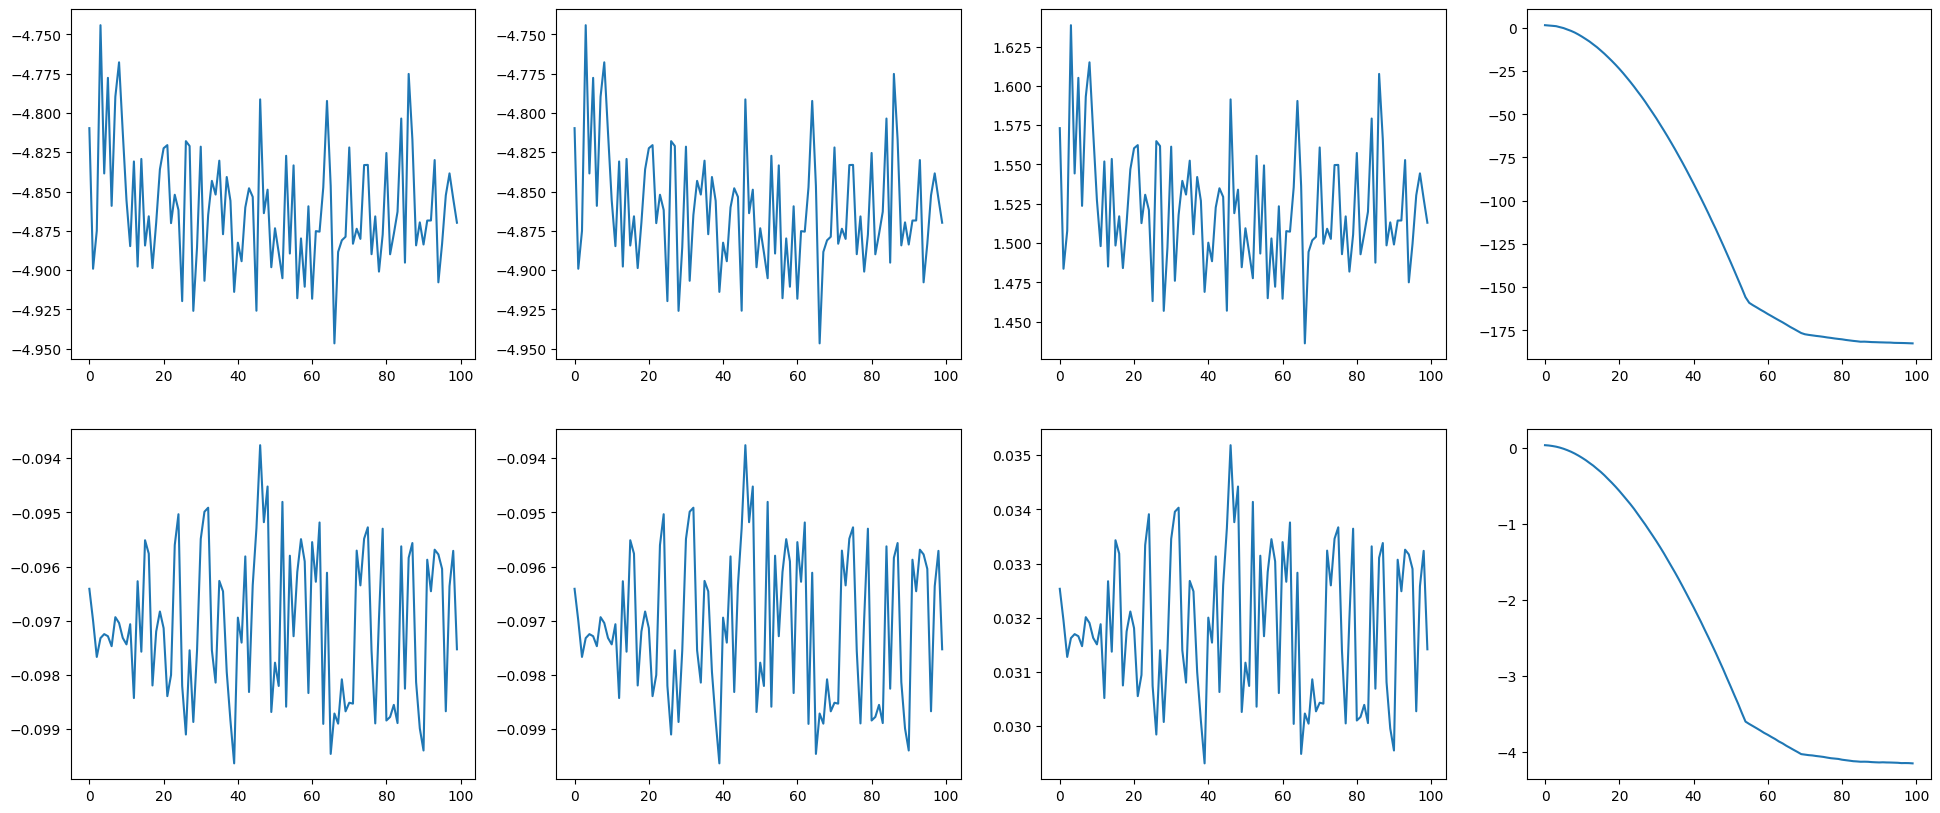

In [7]:
plt.figure(figsize=(24, 10))
plt.subplot(2, 4, 1)
plt.plot(loss_mat[:, 0, 0])
plt.subplot(2, 4, 2)
plt.plot(loss_mat[:, 1, 0])
plt.subplot(2, 4, 3)
plt.plot(loss_mat[:, 2, 0])
plt.subplot(2, 4, 4)
plt.plot(loss_mat[:, 3, 0])

plt.subplot(2, 4, 5)
plt.plot(loss_mat[:, 0, 1])
plt.subplot(2, 4, 6)
plt.plot(loss_mat[:, 1, 1])
plt.subplot(2, 4, 7)
plt.plot(loss_mat[:, 2, 1])
plt.subplot(2, 4, 8)
plt.plot(loss_mat[:, 3, 1])
plt.show()

In [8]:
real, preds = [], []
with torch.no_grad():
    for _, (x, y) in enumerate(test_loader):
        y_pred, _ = model.forward_pass(x)
        preds.extend(list(y_pred.cpu().detach().numpy()))
        real.extend(list(y.cpu().detach().numpy()))

auc = roc_auc_score(real, preds, average=None)

labels_true, labels_pred = np.argmax(real, axis=1), np.argmax(preds, axis=1)

# Compute F1
f1 = f1_score(labels_true, labels_pred, average=None)

# Compute Recall
rec = recall_score(labels_true, labels_pred, average=None)

# Compute NMI
nmi = normalized_mutual_info_score(labels_true, labels_pred)

print(f'AUCROC: \t{auc.mean():.5f}, \t{auc}')
print(f'F1-score: \t{f1.mean():.5f}, \t{f1}')
print(f'Recall: \t{rec.mean():.5f}, \t{rec}')
print(f'NMI: \t\t{nmi:.5f}')

AUCROC: 	0.59354, 	[0.64450343 0.62065071 0.61730972 0.49169929]
F1-score: 	0.28154, 	[0.         0.39154013 0.73460722 0.        ]
Recall: 	0.30406, 	[0.         0.55368098 0.66255319 0.        ]
NMI: 		0.02591


In [9]:
np.unique(np.argmax(test_dataset.y, axis=1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([  20,  652, 2350,   59], dtype=int64))

In [10]:
np.unique(np.argmax(preds, axis=1), return_counts=True)

(array([1, 2], dtype=int64), array([1192, 1889], dtype=int64))

In [11]:
np.unique(np.argmax(train_dataset.y, axis=1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([  18,  586, 2115,   53], dtype=int64))

In [12]:
np.unique(np.argmax(dataset.y, axis=1), return_counts=True)[1] / len(dataset)

array([0.00649266, 0.21153097, 0.76275808, 0.01921828])